# Extremely Randomized Trees

## 1D sigmoid fitting

Note that:

- Random forest does not predict extreme's
- Extra Trees interpolates better
- Both Extra Trees and Random Forest dont extrapolate
- Extra Trees predicts much smoother values
- Extra Trees has lower variance and lower bias

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit, logit
from plotnine import *
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def generate_sigmoid_dataset(samples, lower=-5, upper=5):
    x = np.linspace(lower, upper, 1000).reshape(-1, 1)
    y = expit(x).ravel()
    return x, y


def sample_dataset(x, y, n, noise=None):
    ind = np.random.choice(np.arange(0, x.shape[0]), n)
    if noise is not None:
        y = expit(logit(y) + np.random.normal(0, noise, y.shape))
    return x[ind], y[ind]


def predict_grid(estimator, x, y, x_grid):
    return estimator.fit(x, y).predict(x_grid)


def plot_single_prediction(x_grid, y_pred, y_true, x_sample, y_sample, name='Estimator'):
    df_sample = pd.DataFrame({
        'x': x_sample.ravel(),
        'y': y_sample
    })
    df_pred = pd.concat([
        pd.DataFrame({
            'x': x_grid.ravel(),
            'y': y_pred,
            'method': 'Estimator'
        }),
        pd.DataFrame({
            'x': x_grid.ravel(),
            'y': y_true,
            'method': 'Ground truth'
        })
    ])
    p = ggplot(df_pred) \
        + geom_line(aes('x', 'y', color='method')) \
        + geom_point(df_sample, aes('x', 'y')) \
        + ggtitle(name) \
        + xlim(-5, 5) \
        + ylim(0, 1)
    return p


def plot_multiple_predictions(x_grid, y_preds, y_true, name='Estimator', max_preds=10):
    df_true  = pd.DataFrame({
            'x': x_grid.ravel(),
            'y': y_true,
            'method': 'Ground truth',
            'run': None
        })
    df_mean = pd.DataFrame({
        'x': x_grid.ravel(),
        'y': y_preds.mean(axis=1),
        'method': 'Mean prediction',
        'run': None
    })
    predictions = []
    n_preds = min(y_preds.shape[1], max_preds)
    for column_i in range(n_preds):
        predictions.append(pd.DataFrame({
            'x': x_grid.ravel(),
            'y': y_preds[:, column_i],
            'method': 'Estimator',
            'run': column_i
        }))
    df_predictions = pd.concat(predictions)
    p = ggplot(df_predictions) \
        + geom_line(df_true, aes('x', 'y')) \
        + geom_line(aes('x', 'y', group='run'), color='grey') \
        + geom_line(df_mean, aes('x', 'y'), color='cyan', size=1) \
        + ggtitle(name) \
        + xlim(-5, 5) \
        + ylim(0, 1)
    return p

In [3]:
N_REPEAT = 50
N_SAMPLES = 10

In [4]:
estimators = {
#     'Decision Tree': DecisionTreeRegressor(),
#     'Random Tree': ExtraTreeRegressor(max_features=1),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100),
#     'Totally Random Trees': ExtraTreesRegressor(n_estimators=100, max_features=1),
#     'SVR 0.01': SVR(gamma='scale'),
#     'KNN': KNeighborsRegressor(n_neighbors=1)
}

## Single decision function

Notes:
- Random Forest has a decision function that is much more irregular
- Random Forest does not predict the extreme value, since it is averaged with other trees that do not contain this extreme value
- Extra Trees interpolates more smoothly, it looks linear

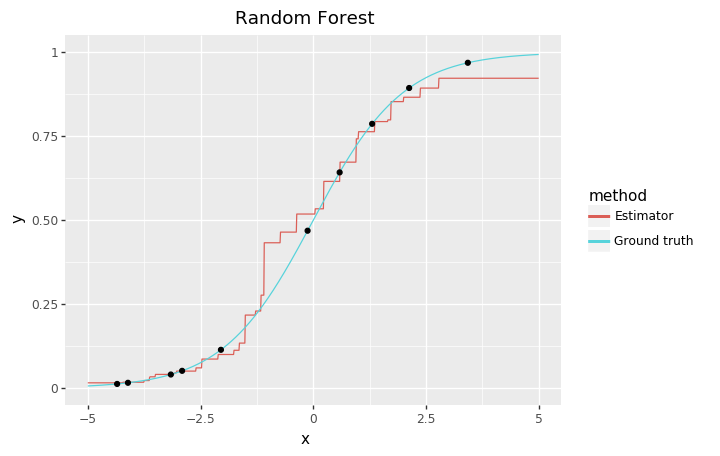

<ggplot: (277423933)>


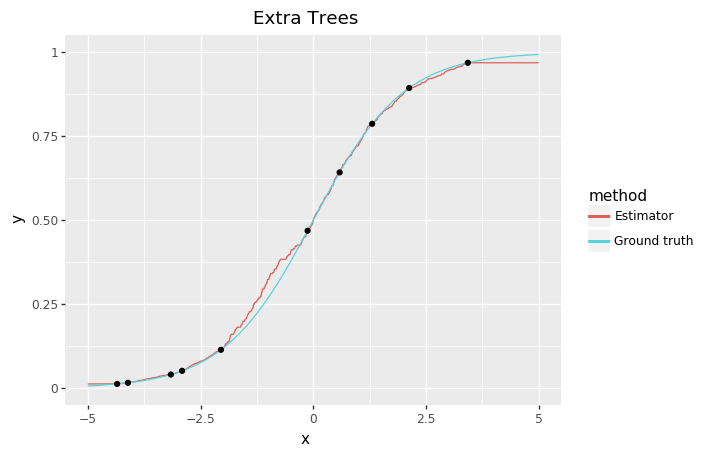

<ggplot: (308817893)>


In [5]:
x_grid, y_true = generate_sigmoid_dataset(N_SAMPLES)
x_sample, y_sample = sample_dataset(x_grid, y_true, N_SAMPLES)
for estimator_name, estimator in estimators.items():
    y_pred = predict_grid(estimator, x_sample, y_sample, x_grid)
    p = plot_single_prediction(x_grid, y_pred, y_true, x_sample, y_sample, estimator_name)
    print(p)

## Group of decision functions

- Spread of Random Forest functions is wider than Extra Trees
- Both Random Forest and Extra Trees don't extrapolate, the maximum value in the dataset is the maximum value predicted. Thus the bias (average deviation of target) is likely higher at the extremes. 
- Extra Trees cut of the sigmoid, the predictions are almost always in the inside bend. 

In [6]:
estimator_predictions = {estimator_name: [] for estimator_name in estimators}
for _ in range(N_REPEAT):
    x_grid, y_true = generate_sigmoid_dataset(10)
    x_sample, y_sample = sample_dataset(x_grid, y_true, N_SAMPLES)
    for estimator_name, estimator in estimators.items():
        y_pred = predict_grid(estimator, x_sample, y_sample, x_grid)
        estimator_predictions[estimator_name].append(y_pred)
for estimator_name, predictions in estimator_predictions.items():
    estimator_predictions[estimator_name] = np.vstack(predictions).T

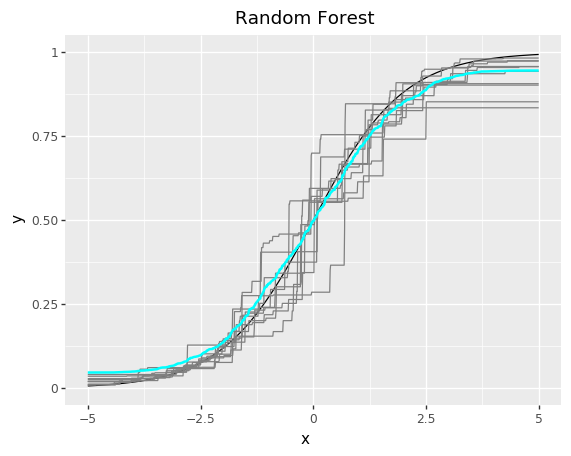

<ggplot: (306555957)>


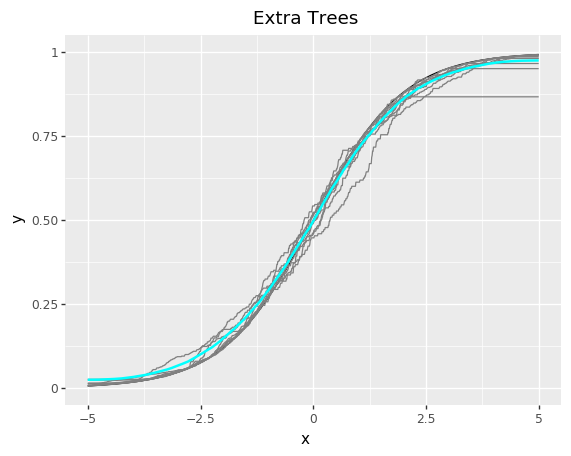

<ggplot: (276760393)>


In [7]:
for estimator, predictions in estimator_predictions.items():
    p = plot_multiple_predictions(x_grid, predictions, y_true, str(estimator))
    print(p)

## Bias and variances

Notes: 
- Bias for Extra Trees is slighly smaller
- Variances for Extra Trees is much lower
- Variance for Random Forest depends on the input-output relation, it is higher in the middle of the sigmoid function

In [8]:
df_errors = {}
max_error = 0
for estimator_name, predictions in estimator_predictions.items():
    bias = (predictions.mean(axis=1) - y_true) ** 2
    variance = (predictions.var(axis=1))
    max_error = max(max_error, (bias + variance).max())
    
    df_error = pd.DataFrame({
        'x': x_grid.ravel(),
        'bias': bias,
        'variance': variance,
        'method': estimator_name
    }).melt(id_vars=('x', 'method'), var_name='error')
    df_errors[estimator_name] = df_error

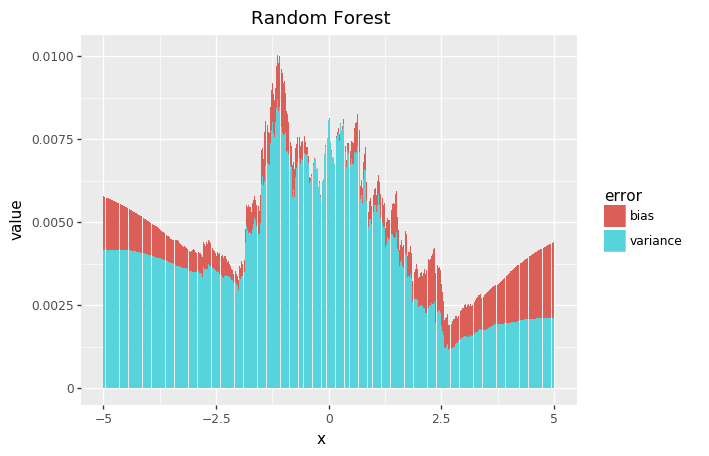

<ggplot: (306571101)>


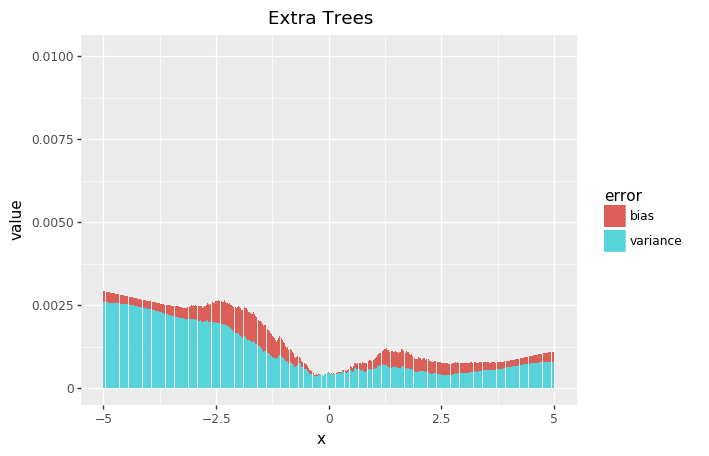

<ggplot: (309673185)>


In [9]:
for estimator_name, df_error in df_errors.items():
    g = ggplot(df_error, aes('x', 'value', fill='error')) \
        + ylim(0, max_error) \
        + geom_bar(stat=stat_identity()) \
        + ggtitle(estimator_name)
    print(g)